# Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms

In this document, we are replicating the work by S.Sim,P.D.Johnson and A.Aspuru-Guzik *Adv.Quantum.Technol.* **2** 1900070 (2019): https://arxiv.org/abs/1905.10876

Consider a parameterized quantum circuit $U(\mathbf{x})$, and define the quantity
$$f(\mathbf{x},\mathbf{y}) = |\langle 0 | U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}$$
This quantity is the fidelity of the two states
$$\begin{align*}
|\psi_{\mathbf{x}}\rangle = U(\mathbf{x})|0\rangle~~&\text{and}~~|\psi_{\mathbf{y}}\rangle = U(\mathbf{y})|0\rangle:\\
|\langle \psi_{\mathbf{y}}|\psi_{\mathbf{x}}\rangle|^{2} &= |\langle 0 |U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}.
\end{align*}$$

Suppose we generate a bunch of random realizations of $\mathbf{x},\mathbf{y}$. This gives us a set of random realizations of $f$; let's call that set $F = \{f_{1}, f_{2}, \cdots \}$.

To calculate the expressibility, we need to do 2 things:
* Generate a _histogram_ of the elements of $F$. The output of this histogram is a set of bins $B = \{(l_1, u_1), (l_2, u_2), \cdots \}$ where $l_{j}$ ($u_j$) denotes the lower (upper) limit of bin $j$. It also produces an empirical probability distribution function $\mathrm{Pr}_{\text{emp}}(j)$, which is simply the probability that a given value of $f$ falls in a bin $j$.
* Given the bins of the histogram, we need to compute the probability that a given fidelity value would fall into bin $j$ if the circuit generating that fidelity is drawn from a Haar-random distribution. If the circuit acts on $n$ qubits, the probability of a given fidelity value $f$ is:
$$ \mathrm{Pr}_{\text{Haar}}(f) = (N -1)*(1-f)^{N-2}~~N=2^{n}.$$
To calculate the probability over a bin of the histogram, we do an integral:
$$\mathrm{Pr}_{\text{Haar}}(j) = \int_{l_{j}}^{u_{j}}  \mathrm{Pr}_{\text{Haar}}(f) ~df =  (1-l_{j})^{N-1}  - (1-u_{j})^{N-1}$$
The expressibility is then estimated as the KL divergence between the empirically-observed probability distribution (i.e., the histogram) and the probability distribution that would result under a Haar-random unitary.
$$\text{Expr} = \mathrm{KL}(\mathrm{Pr}_{\text{emp}}|| \mathrm{Pr}_{\text{Haar}}) = \sum_{j} \mathrm{Pr}_{\text{emp}}(j)\log\left(\frac{\mathrm{Pr}_{\text{emp}}(j)}{\mathrm{Pr}_{\text{Haar}}(j)}\right)$$

$x$

In [1]:
from matplotlib import pyplot
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute,assemble,QuantumCircuit, aqua
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.extensions import *
provider = IBMQ.load_account()

from qiskit.quantum_info import random_unitary

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi, sqrt

from scipy.special import rel_entr
from random import seed
from random import random
import cmath

C:\Users\Saesun Kim\anaconda3\envs\name_of_my_env\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:

#Possible Bin
bins_list=[];
for i in range(76):
    bins_list.append((i)/75)
#Center of the Bean
bins_x=[]    
for i in range(75):
    bins_x.append(bins_list[1]+bins_list[i])
def P_harr(l,u,N):
    return (1-l)**(N-1)-(1-u)**(N-1)
#Harr historgram
P_harr_hist=[]
for i in range(75):
    P_harr_hist.append(P_harr(bins_list[i],bins_list[i+1],2))    
#Imaginary    
j=(-1)**(1/2)

## Idle Circuit

In [40]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
backend = QasmSimulator(method='matrix_product_state')

nshot=10000
nparam=4000
fidelity=[]    
for x in range(nparam):
    th=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    qc.i(qr[0])
    qc.i(qr[0])
    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    fidelity.append(ratio)


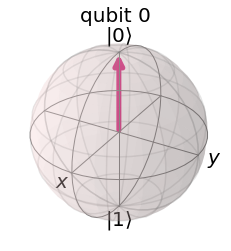

In [41]:
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

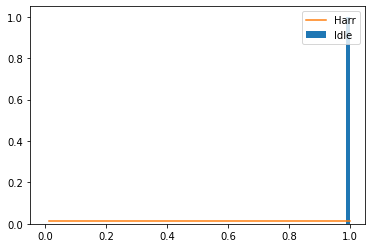

In [42]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Idle', range=[0, 1])
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.legend(loc='upper right')
plt.show()

In [43]:
# example of calculating the kl divergence (relative entropy) with scipy
P_I_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_I_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 4.317 nats


## Circuit A

In [36]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
backend = QasmSimulator(method='matrix_product_state')

nshot=10000
nparam=4000

fidelity=[]    
for x in range(nparam):
    th1=2*pi*random()
    th2=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0])
    qc.rz(th1, qr[0])
    qc.rz(th2, qr[0])
    qc.h(qr[0])
    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0

    
    fidelity.append(ratio)


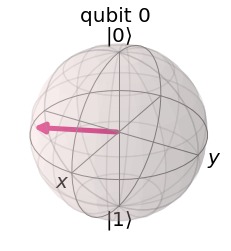

In [37]:
th=2*pi*random()
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])
qc.rz(th, qr[0])
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

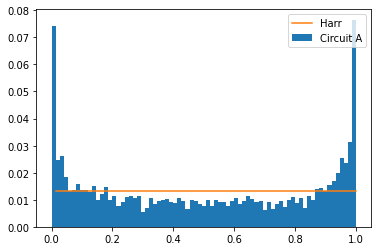

In [38]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Circuit A')
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.legend(loc='upper right')
plt.show()

In [39]:
#Kullback Leibler divergence
P_A_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_A_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 0.208 nats


## Circuit B

In [32]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
backend = QasmSimulator(method='matrix_product_state')

nshot=10000
nparam=4000
fidelity=[]    
for x in range(nparam):
    th1=2*pi*random()
    th2=2*pi*random()
    
    th3=2*pi*random()
    th4=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0])
    qc.rz(th1, qr[0])
    qc.rx(th2, qr[0])
    
    qc.rx(-th3, qr[0])

    qc.rz(-th4, qr[0])
    qc.h(qr[0])
    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    
    fidelity.append(ratio)

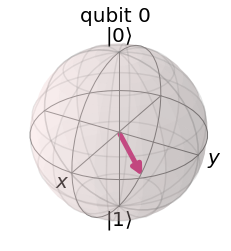

In [33]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
th1=pi/4
th2=0*pi/6
qc.h(qr[0])
qc.rz(th1, qr[0])
qc.rx(th2, qr[0])
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

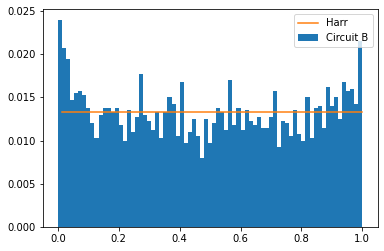

In [34]:
weights = np.ones_like(fidelity)/float(len(fidelity))

plt.hist(fidelity, bins=bins_list, weights=weights, label='Circuit B')
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.legend(loc='upper right')
plt.show()

In [35]:
#Kullback Leibler divergence
P_B_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_B_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 0.021 nats


## Arbitary Unitary

In [28]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
backend = QasmSimulator(method='matrix_product_state')

nshot=10000
nparam=4000
fidelity=[]    
for x in range(nparam):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    u13=UnitaryGate(random_unitary(2))
    qc.append(u13, [qr[0]] )
    u13=UnitaryGate(random_unitary(2))
    qc.append(u13, [qr[0]] )

    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    
    fidelity.append(ratio)   

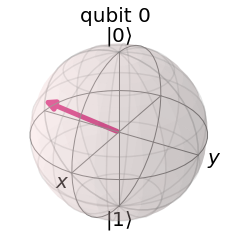

In [29]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
u13=UnitaryGate(random_unitary(2))
qc.append(u13, [qr[0]] )
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

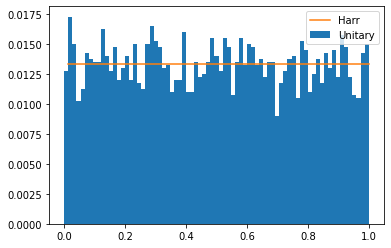

In [30]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Unitary')
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.legend(loc='upper right')
plt.show()

In [31]:
#Kullback Leibler divergence
P_U_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
#Kullback Leibler divergence
kl_pq = rel_entr(P_U_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 0.008 nats
